In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, accuracy_score, recall_score, f1_score
import os
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
import pickle
from sklearn.model_selection import GridSearchCV

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Fall 2024/SML 312/Final Project/data'

train_df = pd.read_csv(file_path + '/train.csv')
val_df = pd.read_csv(file_path + '/val.csv')

Mounted at /content/drive


In [ ]:
# Load precomputed features from FeatureEngineering.ipynb

tfidf_train = np.load(file_path + '/tfidf_train.npy')
tfidf_val = np.load(file_path + '/tfidf_val.npy')

tfidf_feature_names = np.load(file_path + '/tfidf_feature_names.npy', allow_pickle=True)

word2vec_train = np.load(file_path + '/word2vec_train.npy')
word2vec_val = np.load(file_path + '/word2vec_val.npy')

word2vec_smote_tomek_embeddings = np.load(file_path + '/word2vec_smote_tomek_embeddings.npy')
word2vec_smote_tomek_labels = np.load(file_path + '/word2vec_smote_tomek_labels.npy')

lda_train = pd.read_pickle(file_path + '/lda_train.pkl')
lda_val = pd.read_pickle(file_path + '/lda_val.pkl')

with open(file_path + '/lda_topics.pkl', 'rb') as f:
  lda_topics = pickle.load(f)

In [ ]:
word2vec_feature_names = [f"embedding_{i+1}" for i in range(word2vec_train.shape[1])]

lda_feature_names = [f"topic_{i+1}" for i in range(lda_train.shape[1])]

In [ ]:
print(tfidf_train.shape)
print(tfidf_val.shape)
print(tfidf_feature_names.shape)
print(word2vec_train.shape)
print(word2vec_val.shape)
print(word2vec_smote_tomek_embeddings.shape)
print(word2vec_smote_tomek_labels.shape)
print(lda_train.shape)
print(lda_val.shape)
print(len(lda_topics))

(12112, 3000)
(1514, 3000)
(3000,)
(12112, 100)
(1514, 100)
(21960, 100)
(21960,)
(12112, 20)
(1514, 20)
20


In [ ]:
train_df['clean_prompt'] = train_df['clean_prompt'].fillna('')
val_df['clean_prompt'] = val_df['clean_prompt'].fillna('')

In [ ]:
# Function for viewing evaluation metrics

def evaluation_metrics(title, y_pred_prob, y_true, threshold=0.5, plots=True):
  y_pred = (y_pred_prob >= threshold).astype(int)

  precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
  pr_auc = auc(recall, precision)

  accuracy, recall, _f1_score = accuracy_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)

  results = pd.DataFrame({
    'Model': [title],
    'Accuracy': [accuracy],
    'Recall': [recall],
    'F1-Score': [_f1_score],
    'Precision-Recall AUC': [pr_auc]
  })

  print(f"=== {title} Classification Report ===")
  print(results)

  if plots:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Benign', 'Jailbreak'])
    disp.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title(title + ' Confusion Matrix')

    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)

    axes[1].plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(title + ' Precision-Recall Curve')
    axes[1].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    return (results, fig)

  else:
    return (results, None)

In [ ]:
# Function for saving metrics

metrics_file_path = '/content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv'

def save_metrics(metrics, description):
  metrics['Description'] = description

  if os.path.exists(metrics_file_path):
    existing_metrics = pd.read_csv(metrics_file_path)
    combined_metrics = pd.concat([existing_metrics, metrics], ignore_index=True)
  else:
    combined_metrics = metrics

  combined_metrics.to_csv(metrics_file_path, index=False, encoding='utf-8')
  print(f"Metrics saved to {metrics_file_path}")

In [ ]:
# Function for viewing top n feature coefficients

def feature_coefs(model, feature_names, top_n=None):
  coefs = model.coef_[0]

  feature_coefs = pd.DataFrame({
      'Feature': feature_names,
      'Coefficient': coefs
  })

  feature_coefs = feature_coefs.sort_values(by='Coefficient', key=lambda x: x.abs(), ascending=False)

  if top_n:
    print(feature_coefs.head(top_n))
  else:
   print(feature_coefs)

=== Logistic Regression Classification Report ===
                 Model  Accuracy  Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.904227     0.0       0.0                0.1769


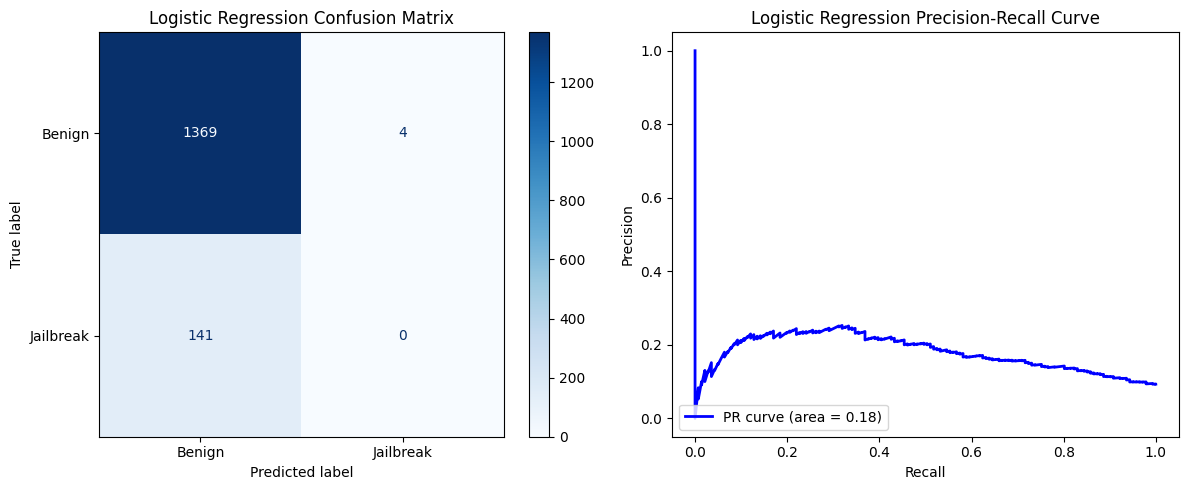

                    Feature  Coefficient
0         scaled_word_count     1.425338
1         scaled_char_count    -1.140576
3     scaled_question_count    -0.242427
2  scaled_exclamation_count     0.129089
4  scaled_punctuation_count    -0.056288


In [ ]:
# Features: 'scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']],
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']],
])

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]

results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: scaled_word_count, scaled_char_count, scaled_exclamation_count, scaled_question_count, scaled_punctuation_count')

feature_coefs(log_reg, ['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'])

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.928005  0.404255  0.511211              0.624167


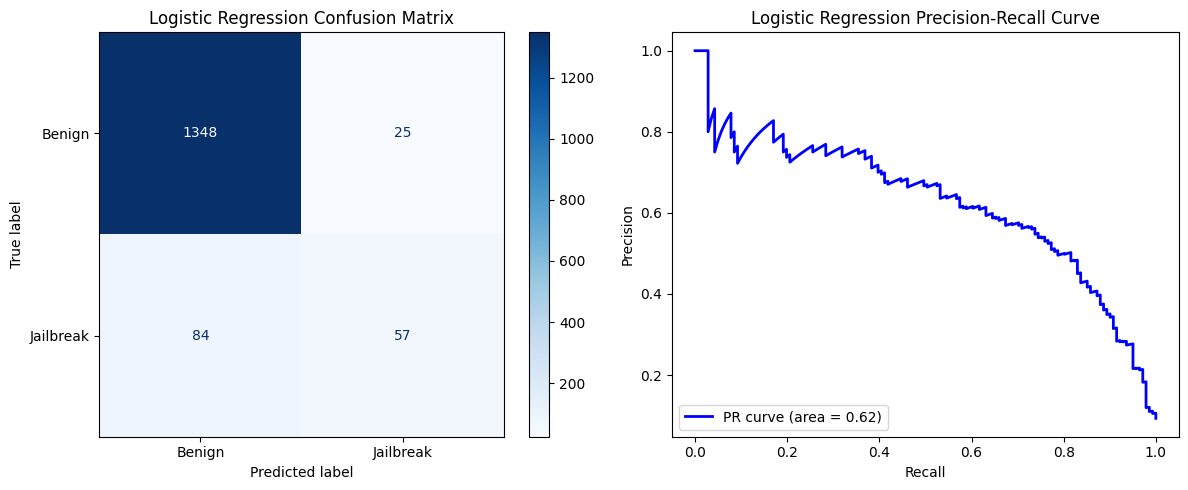

             Feature  Coefficient
2671  targetlanguage    -4.352180
1334         illegal     2.901198
953            ethic     2.534296
1729           moral     2.531713
1462       jailbreak     2.422083
2647           swear     2.301255
1078          filter     2.240813
106           always     2.228367
1069       fictional     2.211746
2315            rule     2.204307


In [ ]:
# Features: TF-IDF, 'scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'

# Loaded TF-IDF features have parameter max_features = 3000

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']].values,
    tfidf_train,
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']].values,
    tfidf_val,
])

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, scaled_word_count, scaled_char_count, scaled_exclamation_count, scaled_question_count, scaled_punctuation_count')

feature_coefs(log_reg, ['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'] + tfidf_feature_names.tolist(), top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.928005  0.404255  0.511211               0.62566


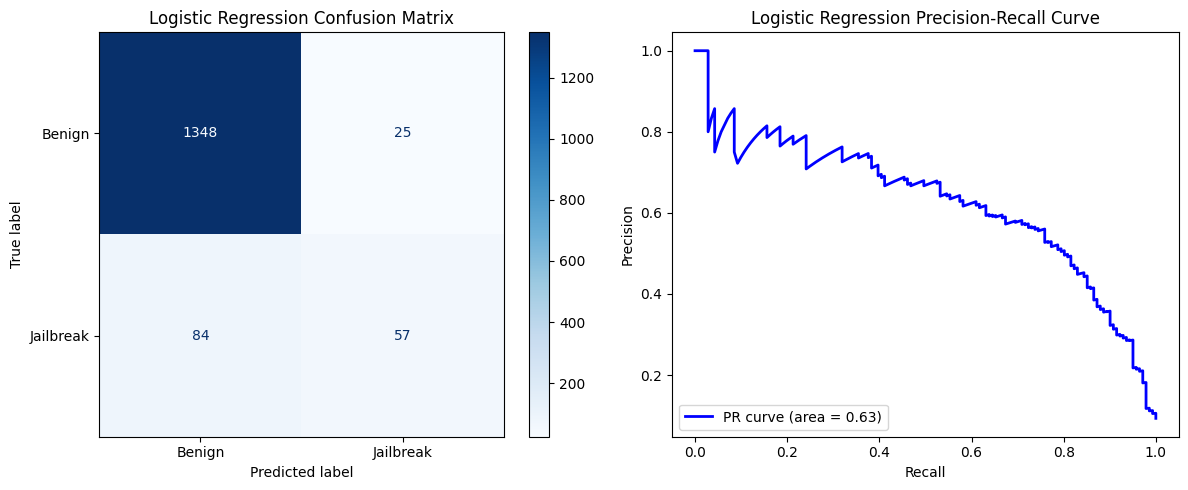

             Feature  Coefficient
2666  targetlanguage    -4.378919
1329         illegal     2.949346
948            ethic     2.547152
1724           moral     2.516321
1457       jailbreak     2.420905
2642           swear     2.301928
101           always     2.269798
1073          filter     2.251423
409          chatgpt     2.222744
1064       fictional     2.207917


In [ ]:
# Features: TF-IDF

train_features = tfidf_train

val_features = tfidf_val

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF')

feature_coefs(log_reg, tfidf_feature_names.tolist(), top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.900925  0.822695   0.60733              0.604239


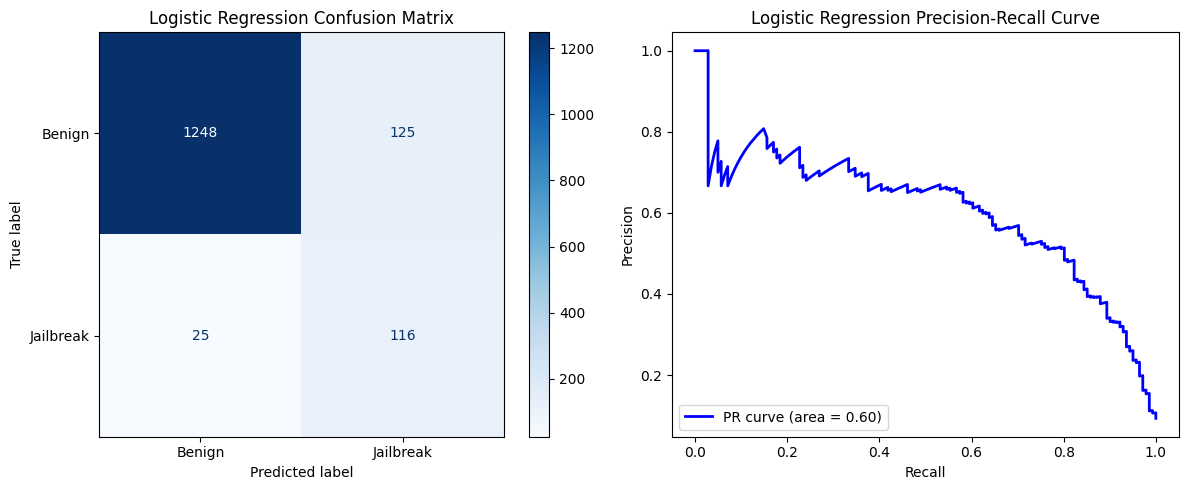

             Feature  Coefficient
2666  targetlanguage    -7.223185
1329         illegal     4.033665
1457       jailbreak     4.020184
1724           moral     3.037550
948            ethic     3.014859
1064       fictional     2.952386
2642           swear     2.905184
1835          openai     2.832418
1320    hypothetical     2.807576
1073          filter     2.716823


In [ ]:
# Features: TF-IDF, Parameters: class_weight='balanced'

train_features = tfidf_train

val_features = tfidf_val

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, Parameters: class_weight="balanced"')

feature_coefs(log_reg, tfidf_feature_names.tolist(), top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.903567  0.808511  0.609626              0.600982


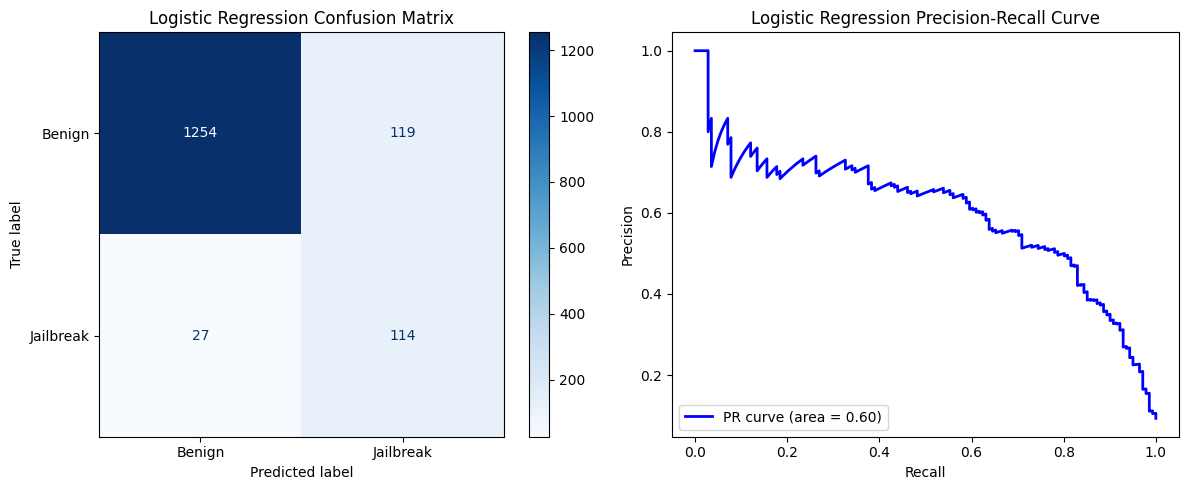

             Feature  Coefficient
2671  targetlanguage    -7.157508
1462       jailbreak     4.034145
1334         illegal     3.998866
1729           moral     3.046633
953            ethic     2.979643
1069       fictional     2.969343
2647           swear     2.938672
1840          openai     2.843691
1325    hypothetical     2.800514
1078          filter     2.721344


In [ ]:
# Features: TF-IDF, 'scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'
# Parameters: class_weight='balanced'

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']].values,
    tfidf_train,
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count']].values,
    tfidf_val,
])

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, scaled_word_count, scaled_char_count, scaled_exclamation_count, scaled_question_count, scaled_punctuation_count; Parameters: class_weight="balanced"')

feature_coefs(log_reg, ['scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', 'scaled_punctuation_count'] + tfidf_feature_names.tolist(), top_n=10)

The inclusion of the count features ('scaled_word_count', 'scaled_char_count', 'scaled_exclamation_count', 'scaled_question_count', and 'scaled_punctuation_count') does not appear to improve logistic regression model performance. To avoid overfitting and keep models as simple as possible, I will not use them.

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.891017  0.780142  0.571429              0.583767


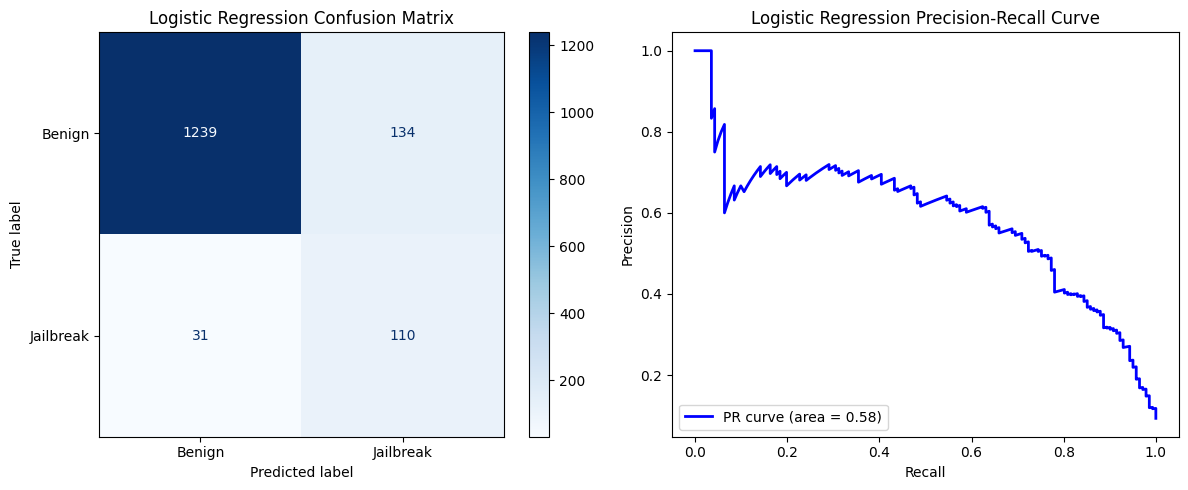

             Feature  Coefficient
1457       jailbreak     4.384762
2666  targetlanguage    -4.023712
356          captain     2.391393
825          dungeon     2.254402
712      demonstrate     2.234413
409          chatgpt     2.077036
1320    hypothetical     2.068901
2197         reflect     2.062320
784          display     2.033081
109              amp     2.007507


In [ ]:
# Features: TF-IDF, Word2Vec
# Parameters: class_weight='balanced'

train_features = np.hstack([
    tfidf_train,
    word2vec_train
])

val_features = np.hstack([
    tfidf_val,
    word2vec_val
])

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, Word2Vec; Parameters: class_weight="balanced"')

feature_coefs(log_reg, tfidf_feature_names.tolist() + word2vec_feature_names, top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression   0.82959  0.808511  0.469136               0.51762


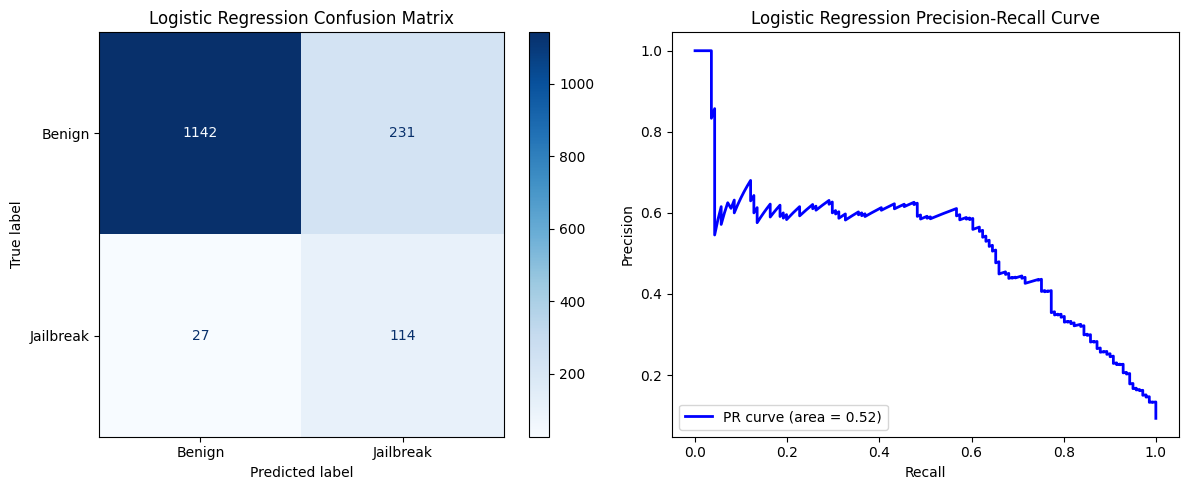

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
         Feature  Coefficient
20  embedding_21     1.719364
8    embedding_9     1.644010
43  embedding_44     1.607357
97  embedding_98    -1.445507
68  embedding_69    -1.415926
29  embedding_30     1.376421
27  embedding_28     1.320817
61  embedding_62    -1.150186
36  embedding_37     1.148795
80  embedding_81     1.094875


In [ ]:
# Features: Word2Vec
# Parameters: class_weight='balanced'

train_features = word2vec_train

val_features = word2vec_val

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: Word2Vec; Parameters: class_weight="balanced"')

feature_coefs(log_reg, word2vec_feature_names, top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression   0.82893  0.808511  0.468172              0.531402


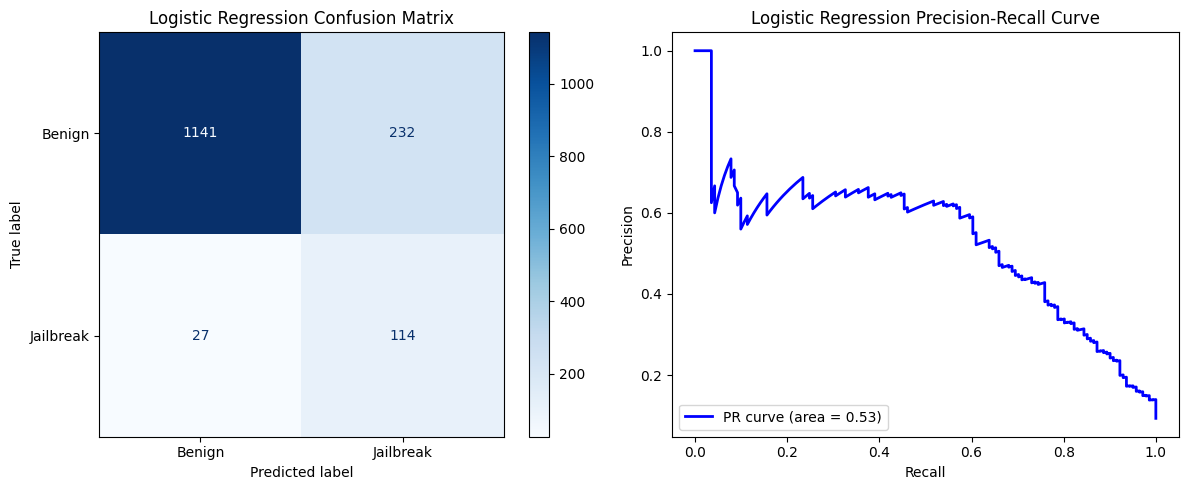

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
         Feature  Coefficient
97  embedding_98    -2.267808
20  embedding_21     2.264874
27  embedding_28     2.187163
8    embedding_9     2.118564
36  embedding_37     1.785765
24  embedding_25    -1.706100
43  embedding_44     1.662052
37  embedding_38     1.644106
61  embedding_62    -1.554221
11  embedding_12    -1.551833


In [ ]:
# Features: Word2Vec (Smote + Tomek Links resampled)

train_features = word2vec_smote_tomek_embeddings

val_features = word2vec_val

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, word2vec_smote_tomek_labels)

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: Word2Vec (Smote + Tomek Links resampled)')

feature_coefs(log_reg, word2vec_feature_names, top_n=10)

Word2Vec embeddings (both regular and resampled Smote and Tomek Links versions) achieve lower performance on logistic regression models than TF-IDF.

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.873844  0.801418  0.541966              0.559543


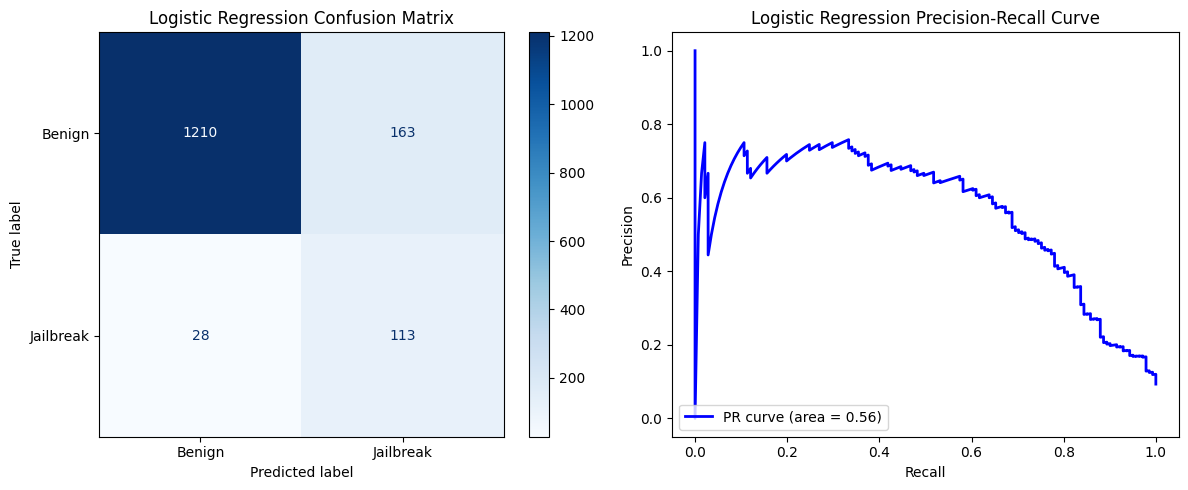

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
     Feature  Coefficient
18  topic_19     5.862207
11  topic_12    -3.826539
17  topic_18    -3.523998
19  topic_20     3.350191
10  topic_11     2.753294
16  topic_17     2.481333
8    topic_9    -2.476820
0    topic_1    -1.531733
7    topic_8     1.179711
14  topic_15    -1.169635


In [ ]:
# Features: LDA
# Parameters: class_weight='balanced'

train_features = lda_train

val_features = lda_val

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: LDA; Parameters: class_weight="balanced"')

feature_coefs(log_reg, lda_feature_names, top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.901585  0.801418  0.602667              0.617991


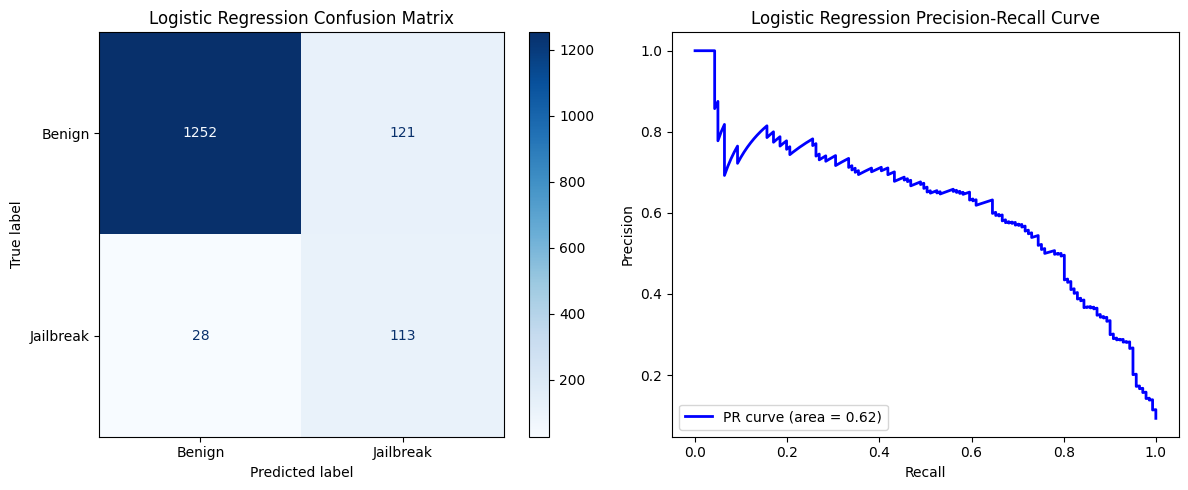

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
             Feature  Coefficient
2666  targetlanguage    -6.105836
3018        topic_19     4.411371
1457       jailbreak     3.858609
2783            true     2.544983
825          dungeon     2.478318
4         absolutely     2.300618
1562            link     2.285146
2375            send    -2.265384
2642           swear     2.204000
1550            life    -2.200745


In [ ]:
# Features: TF-IDF, LDA
# Parameters: class_weight='balanced'

train_features = np.hstack([
    tfidf_train,
    lda_train
])

val_features = np.hstack([
    tfidf_val,
    lda_val
])

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: TF-IDF, LDA; Parameters: class_weight="balanced"')

feature_coefs(log_reg, tfidf_feature_names.tolist() + lda_feature_names, top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.848085  0.808511  0.497817              0.545149


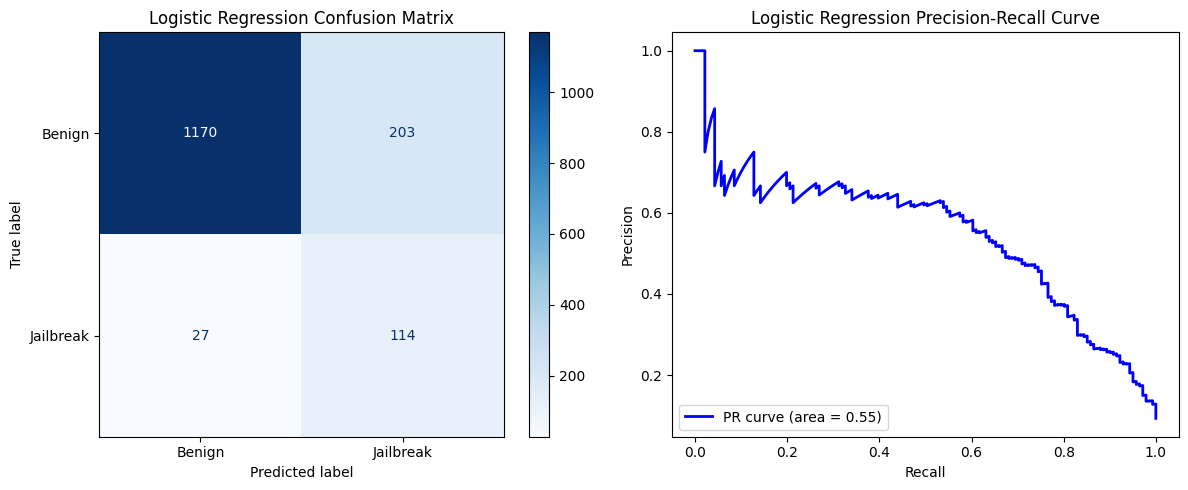

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
          Feature  Coefficient
118      topic_19     2.837493
100       topic_1    -2.100656
20   embedding_21     1.899339
8     embedding_9     1.516157
117      topic_18    -1.481225
119      topic_20     1.479259
96   embedding_97    -1.321944
29   embedding_30     1.297480
68   embedding_69    -1.267765
43   embedding_44     1.254230


In [ ]:
# Features: Word2Vec, LDA
# Parameters: class_weight='balanced'

train_features = np.hstack([
    word2vec_train,
    lda_train
])

val_features = np.hstack([
    word2vec_val,
    lda_val
])

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: Word2Vec, LDA; Parameters: class_weight="balanced"')

feature_coefs(log_reg, word2vec_feature_names + lda_feature_names, top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.901585  0.801418  0.602667              0.615836


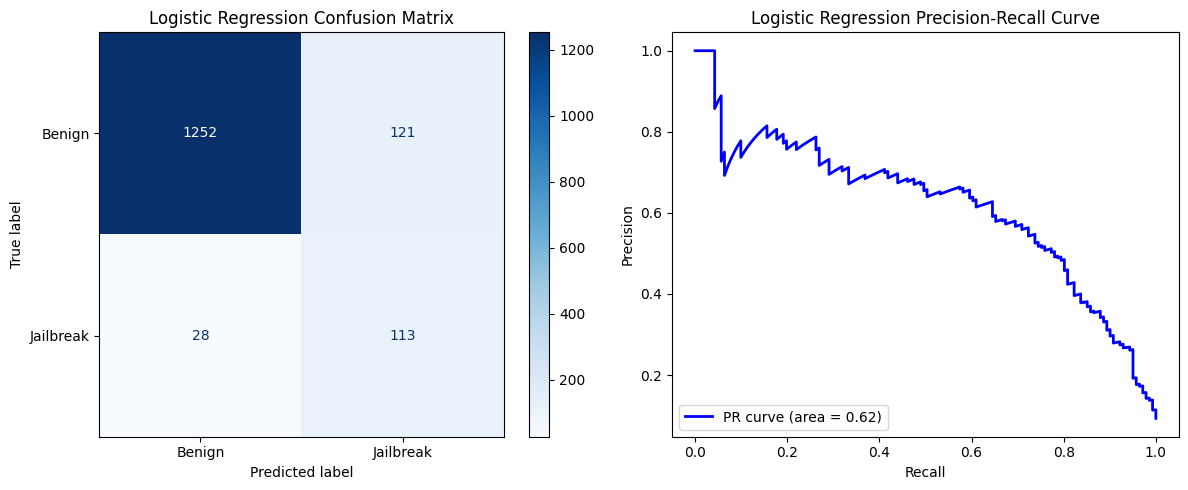

             Feature  Coefficient
2668  targetlanguage    -6.108771
3020        topic_19     4.412755
1459       jailbreak     3.867380
2785            true     2.539306
827          dungeon     2.521862
2377            send    -2.307737
6         absolutely     2.274164
1564            link     2.252662
1552            life    -2.226278
2644           swear     2.197702


In [ ]:
# Features: scaled_word_count, scaled_char_count, TF-IDF, LDA
# Parameters: class_weight='balanced'

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count']].values,
    tfidf_train,
    lda_train
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count']].values,
    tfidf_val,
    lda_val
])

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: scaled_word_count, scaled_char_count, TF-IDF, LDA; Parameters: class_weight="balanced"')

feature_coefs(log_reg, ['scaled_word_count', 'scaled_char_count'] + tfidf_feature_names.tolist() + lda_feature_names, top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.900264  0.801418  0.599469              0.617322


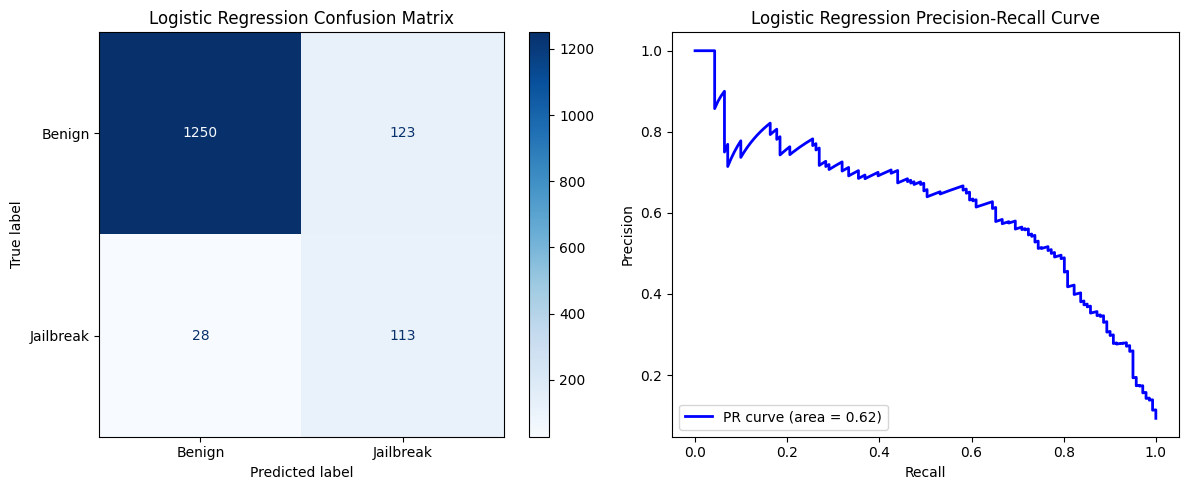

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
             Feature  Coefficient
2669  targetlanguage    -6.074018
3021        topic_19     4.397498
1460       jailbreak     3.884100
2786            true     2.553065
828          dungeon     2.521331
2378            send    -2.307401
1565            link     2.279904
7         absolutely     2.271410
1553            life    -2.219690
2645           swear     2.198450


In [ ]:
# Features: scaled_word_count, scaled_char_count, scaled_question_count, TF-IDF, LDA
# Parameters: class_weight='balanced'

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_train,
    lda_train
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_val,
    lda_val
])

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: scaled_word_count, scaled_char_count scaled_question_count, TF-IDF, LDA; Parameters: class_weight="balanced"')

feature_coefs(log_reg, ['scaled_word_count', 'scaled_char_count', 'scaled_question_count'] + tfidf_feature_names.tolist() + lda_feature_names, top_n=10)

=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.902906  0.808511     0.608              0.600049


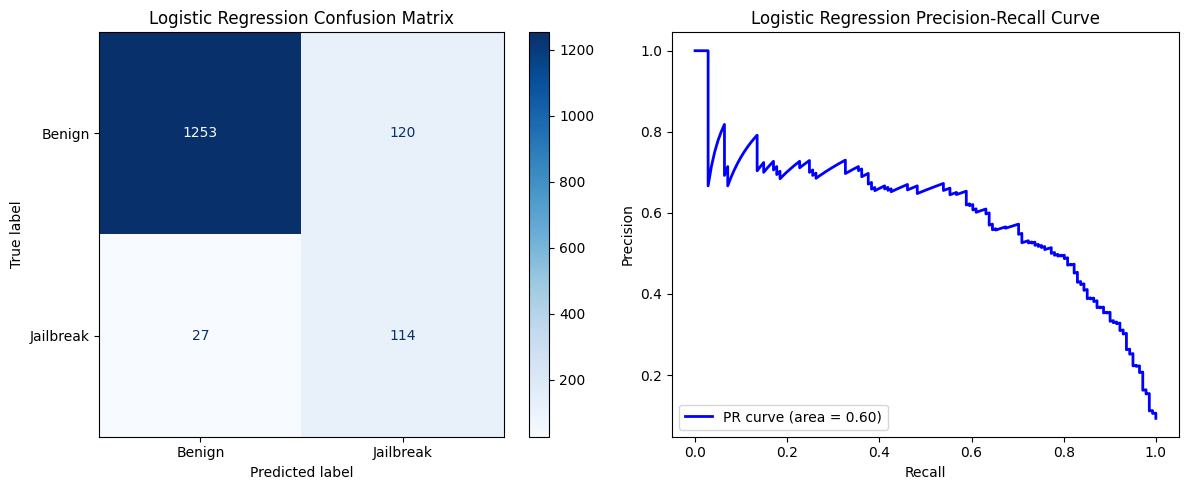

Metrics saved to /content/drive/MyDrive/Fall 2024/SML 312/Final Project/data/results.csv
             Feature  Coefficient
2669  targetlanguage    -7.194099
1332         illegal     4.020191
1460       jailbreak     4.009266
1727           moral     3.024147
951            ethic     3.009879
1067       fictional     2.954217
2645           swear     2.889928
1838          openai     2.836957
1323    hypothetical     2.791405
1076          filter     2.711785


In [ ]:
# Features: scaled_word_count, scaled_char_count, scaled_question_count, TF-IDF
# Parameters: class_weight='balanced'

train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_train
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_val
])

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])
save_metrics(results, 'Features: scaled_word_count, scaled_char_count scaled_question_count, TF-IDF; Parameters: class_weight="balanced"')

feature_coefs(log_reg, ['scaled_word_count', 'scaled_char_count', 'scaled_question_count'] + tfidf_feature_names.tolist(), top_n=10)

I found that the following two logistic regression models performed best:
1. Features: TF-IDF scores; Parameters: class_weight = 'balanced'
2. Features: scaled_word_count, scaled_char_count, scaled_question_count, TF-IDF scores, LDA topic scores; Parameters: class_weight = 'balanced

Below, I will do hyperparameter tuning for both, optimizing for recall.

In [ ]:
train_features = tfidf_train
val_features = tfidf_val

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(train_features, train_df['jailbreak'])

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.900925  0.822695   0.60733              0.604239


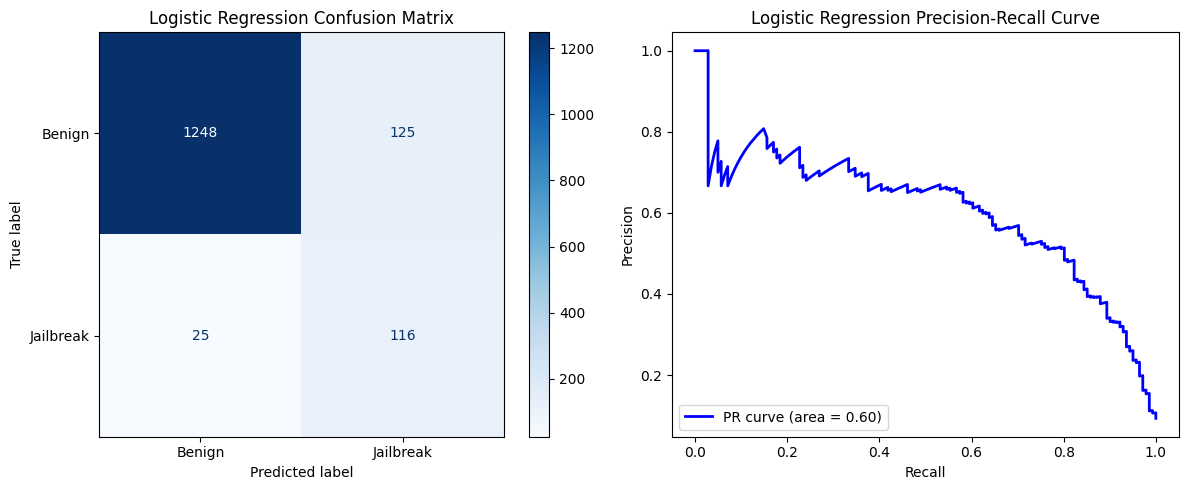

In [ ]:
train_features = tfidf_train
val_features = tfidf_val

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', **best_params)
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])

In [ ]:
train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_train,
    lda_train
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_val,
    lda_val
])

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2'],
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(train_features, train_df['jailbreak'])

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


=== Logistic Regression Classification Report ===
                 Model  Accuracy    Recall  F1-Score  Precision-Recall AUC
0  Logistic Regression  0.900264  0.801418  0.599469              0.617322


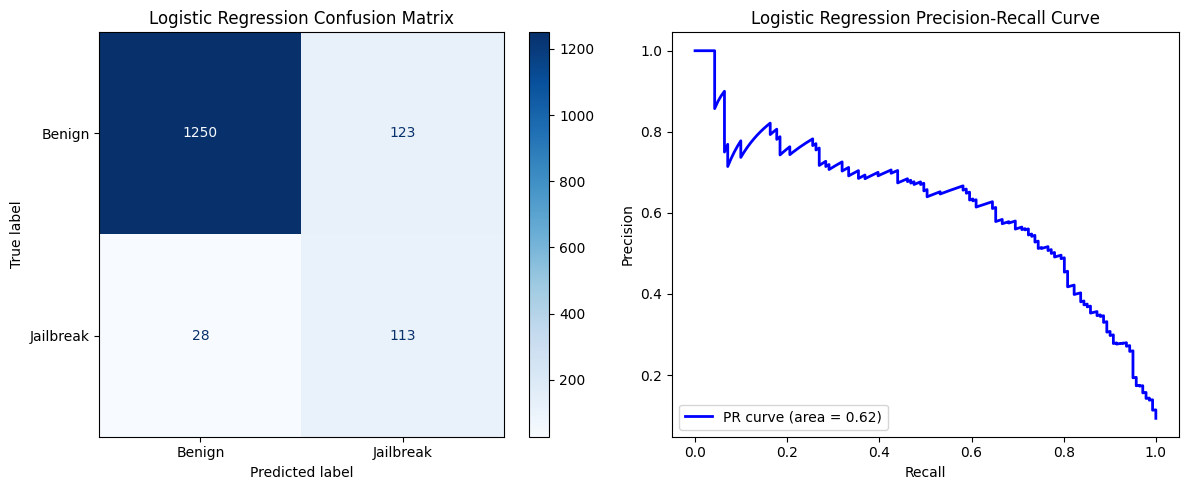

In [ ]:
train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_train,
    lda_train
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_val,
    lda_val
])

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', **best_params)
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]
results, fig = evaluation_metrics('Logistic Regression', y_pred_prob, val_df['jailbreak'])

I will inspect recall and accuracy results over various probability thresholds to select one.

In [ ]:
train_features = tfidf_train
val_features = tfidf_val

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for threshold in thresholds:
  results, fig = evaluation_metrics(f'Logistic Regression (threshold={threshold})', y_pred_prob, val_df['jailbreak'], threshold=threshold, plots=False)

=== Logistic Regression (threshold=0.2) Classification Report ===
                                 Model  Accuracy    Recall  F1-Score  \
0  Logistic Regression (threshold=0.2)  0.681638  0.964539  0.360743   

   Precision-Recall AUC  
0              0.604239  
=== Logistic Regression (threshold=0.25) Classification Report ===
                                  Model  Accuracy    Recall  F1-Score  \
0  Logistic Regression (threshold=0.25)  0.757596  0.943262  0.420221   

   Precision-Recall AUC  
0              0.604239  
=== Logistic Regression (threshold=0.3) Classification Report ===
                                 Model  Accuracy    Recall  F1-Score  \
0  Logistic Regression (threshold=0.3)  0.809115  0.921986  0.473588   

   Precision-Recall AUC  
0              0.604239  
=== Logistic Regression (threshold=0.35) Classification Report ===
                                  Model  Accuracy    Recall  F1-Score  \
0  Logistic Regression (threshold=0.35)  0.840159  0.893617  0.51012

In [ ]:
train_features = np.hstack([
    train_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_train,
    lda_train
])

val_features = np.hstack([
    val_df[['scaled_word_count', 'scaled_char_count', 'scaled_question_count']].values,
    tfidf_val,
    lda_val
])

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(train_features, train_df['jailbreak'])

y_pred_prob = log_reg.predict_proba(val_features)[:, 1]

thresholds = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for threshold in thresholds:
  results, fig = evaluation_metrics(f'Logistic Regression (threshold={threshold})', y_pred_prob, val_df['jailbreak'], threshold=threshold, plots=False)

=== Logistic Regression (threshold=0.2) Classification Report ===
                                 Model  Accuracy    Recall  F1-Score  \
0  Logistic Regression (threshold=0.2)  0.706737  0.950355  0.376404   

   Precision-Recall AUC  
0              0.617322  
=== Logistic Regression (threshold=0.25) Classification Report ===
                                  Model  Accuracy    Recall  F1-Score  \
0  Logistic Regression (threshold=0.25)  0.768824  0.914894  0.424342   

   Precision-Recall AUC  
0              0.617322  
=== Logistic Regression (threshold=0.3) Classification Report ===
                                 Model  Accuracy    Recall  F1-Score  \
0  Logistic Regression (threshold=0.3)  0.815059  0.893617  0.473684   

   Precision-Recall AUC  
0              0.617322  
=== Logistic Regression (threshold=0.35) Classification Report ===
                                  Model  Accuracy   Recall  F1-Score  \
0  Logistic Regression (threshold=0.35)  0.840819  0.87234  0.505133 

I select thresholds of 0.35, which achieves a validation accuracy of 0.84 and a validation recall of 0.87-0.89.